# Your work here!

In [1]:
import numpy as np 
import pandas as pd
import torch, torch.nn as nn, time
from torch.utils.data import Dataset, DataLoader

from nnViz_pytorch import *
import matplotlib.pylab as plt
plt.style.use(['Solarize_Light2'])
%matplotlib inline
!pwd
N = 96 
F = 4
CPU = torch.device('cpu')
device = CPU

/home/irina/Hackathon/environmental-hackathon


In [2]:
test_red = np.load("data/test_data_reduced.npy")
test_red.shape

(9898, 960)

In [3]:
pred_red = np.load("data/test_pred_reduced.npy")
pred_red.shape

(9898, 960)

In [4]:
test = np.load("data/test_data_complete.npy")
test.shape

(9898, 2112)

In [5]:
pred = np.load("data/test_smoo_complete.npy")
pred.shape

(9898, 2112)

In [6]:
a = np.load("anom1.npy")


In [7]:
def deviation(a,b):
    c = np.array(a) - np.array(b)
    # in one window:
    # mse = np.square(c).mean(axis=None)
    # in 2 windows 
    #mse = max([np.square(c[i*N//2:(i+1)*N//2]).mean(axis=None) for i in range(2)])    
    # in 3 overlaping windows 
    mse = max([np.square(c[j:j+N//2]).mean(axis=None) for j in [0, N//4, N//2]])    
    dev = max(abs(c))
    return dev, mse

def column_dev( aa, bb):
    dev = [ deviation(a,b) for a, b in zip(aa, bb)]
    #print(dev)
    return np.array(dev)

def deviation_stats( t, p ):
    dev=np.zeros((t.shape[0], 16))
    mse=np.zeros((t.shape[0], 16))
    dev.shape
    for j in [0,1,2,3]:
        p1 = p[:,j*N:(j+1)*N]
        for i in [0,1,2,3]:
            t1 = t[:,(j*4+i)*N:(j*4+i+1)*N]
            d = column_dev(t1, p1)
            dev[:,j*4+i] = d[:,0]
            mse[:,j*4+i] = d[:,1]
    d = np.zeros((t.shape[0], 4))
    m = np.zeros((t.shape[0], 4))
    
    for i in [0,1,2,3]:
        d[:, i] = np.max(dev[:,i*4:(i+1)*4], axis=1)
        m[:, i] = np.max(mse[:,i*4:(i+1)*4], axis=1)    
            
    return d, m

In [8]:
dev, mse = deviation_stats(test, test_red)
dev = np.array(dev)
dev.shape
d1 = test[20]            # regular
d2 = test[5502]          # brocken sensor
d3 = test[3050]          # deviates strongly
d4 = test[9298]   

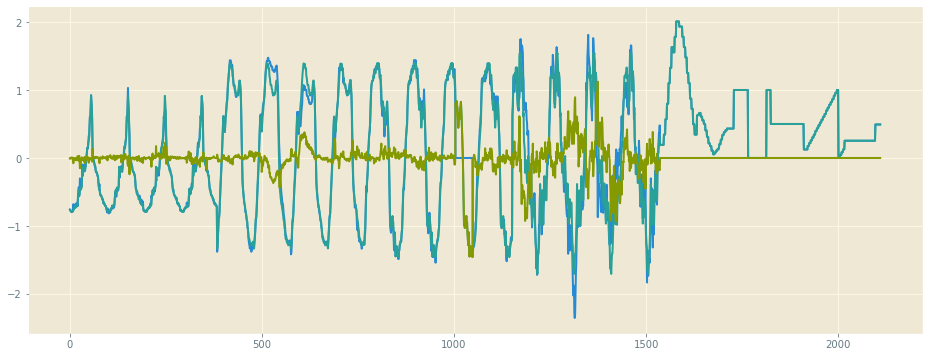

In [9]:
plt.figure(figsize=(16,6));
i = 5502
plt.plot(test[i])
plt.plot(pred[i])
plt.plot(pred[i]-test[i])

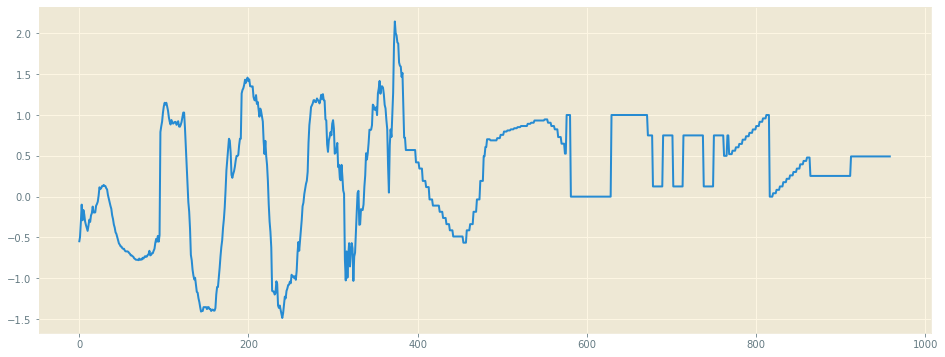

In [10]:
plt.figure(figsize=(16,6));
plt.plot(test_red[20])

In [11]:
def renormalize(s):
#    print("renormalized coeffs:",  s.mean(axis = 0), s.std(axis=0))
    return (s - s.mean(axis = 0))/s.std(axis=0)
    
def find_spikes(seq, th=5):
    seq = renormalize(seq)
    a = [i for i, s in enumerate(seq) if s > th]
    return a

def find_all_spikes(dev, a, th=10):
    anom = []
    anom=np.append(anom,a)
    for c in range(dev.shape[1]): 
   #     print("c=", c)
        seq = renormalize(dev[:,c])
        for i in anom:
            seq[int(i)] = 0.
        a = find_spikes(seq, th)
        anom=np.append(anom,a)
    return anom

In [12]:
def the_curve(seq, a):
    thr = np.linspace(1, 20, num=1000)
    na  = []
    for th in thr:
        ad = find_all_spikes(seq, a, th)
        na.append(len(ad))    
    return thr, na

def the_curve2(a):
    thr = np.linspace(1, 20, num=1000)
    na  = []
    n1  = []
    for th in thr:
        ad = find_all_spikes(dev, a, th)
        n1.append(len(ad))
        ae = find_all_spikes(mse, ad, th)
        na.append(len(ae))    
    return thr, na, n1

In [13]:
dev.shape

(9898, 4)

In [14]:
th=7.1
ad = find_all_spikes(dev, a, th)
print(len(set(ad)))
th=7.06
ae = find_all_spikes(mse, ad, th)
print(len(set(ae)))

156
200


In [15]:
th=3
ad = find_all_spikes(dev, a, th)
print(len(set(ad)))
th=13.3
ae = find_all_spikes(mse, ad, th)
print(len(set(ae)))

190
200


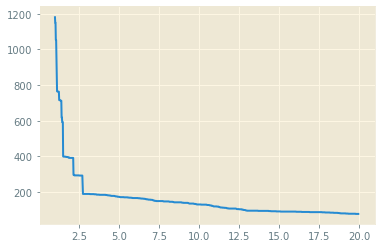

In [16]:
thresholds, outliers = the_curve(dev,a)
plt.plot(thresholds, outliers);


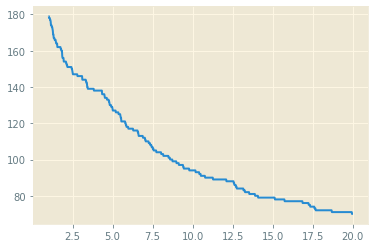

In [17]:
thresholds, outliers = the_curve(mse,a)
plt.plot(thresholds, outliers);

In [18]:
thresholds, out, out1 = the_curve2(a)

(0.0, 300.0)

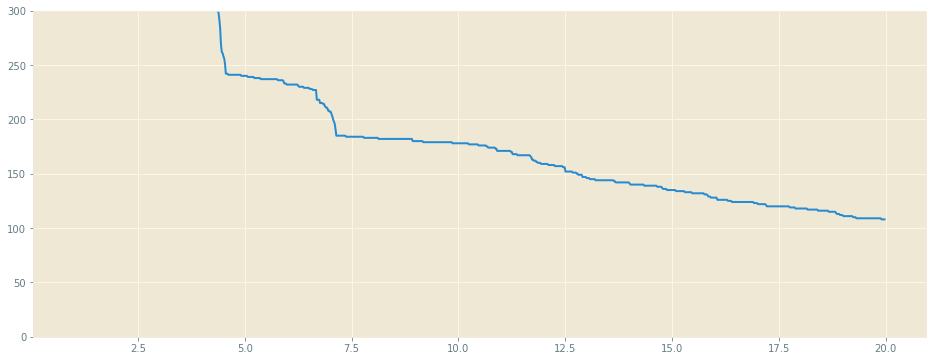

In [19]:
plt.figure(figsize=(16,6));
plt.plot(thresholds, out)
plt.ylim(0,300)
#plt.plot(thresholds, out1)

In [20]:
a

array([  49,  162,  180,  277,  420,  439,  667,  686,  745, 1147, 1358,
       1394, 1621, 1804, 1861, 1940, 3059, 3152, 4009, 4380, 4381, 4695,
       4819, 4870, 5074, 5092, 5158, 5269, 5303, 5502, 5562, 5589, 5778,
       5788, 6066, 6269, 6284, 6303, 6378, 6702, 6940, 7443, 7673, 7688,
       8008, 8103, 8380, 8450, 8623, 8765, 8866, 8983, 9042, 9253, 9654])

In [21]:
def disp_anom(seq, a):
    plt.figure(figsize=(16,6));
    s = renormalize(seq)
    s = [min(10, ss) for ss in s]
    plt.plot(s)
    s = np.array(s)
    a = [int(aa) for aa in a]
    a.sort()
    #print(a)
    plt.plot(a, s[a], "ro")

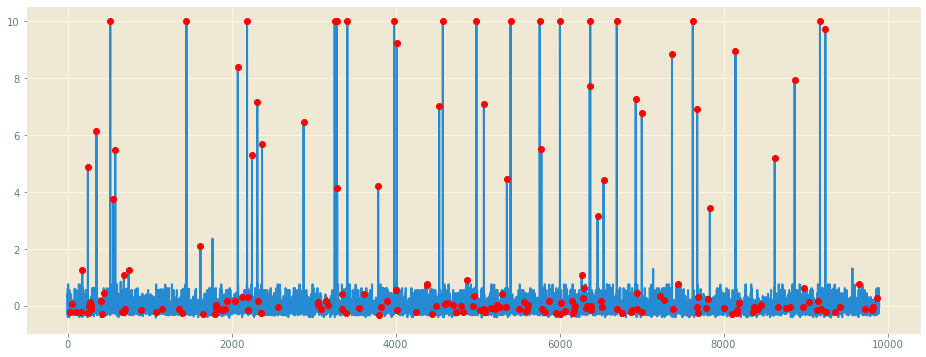

In [22]:
disp_anom(dev[:,0], ad)

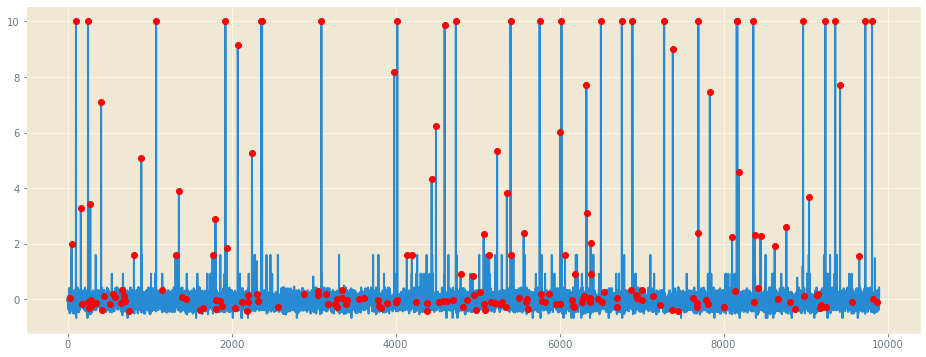

In [23]:
disp_anom(dev[:,1], ae)

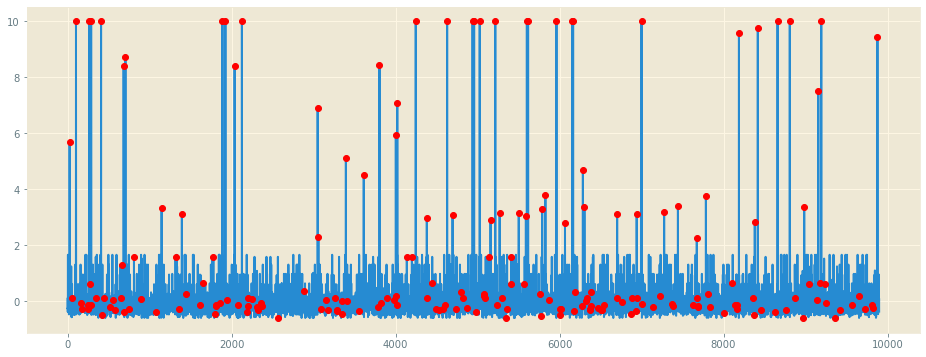

In [24]:
disp_anom(dev[:,2], ae)

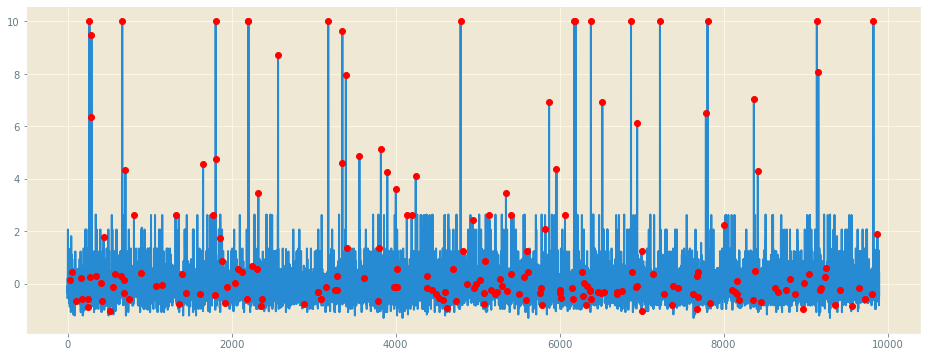

In [25]:
disp_anom(dev[:,3], ae)

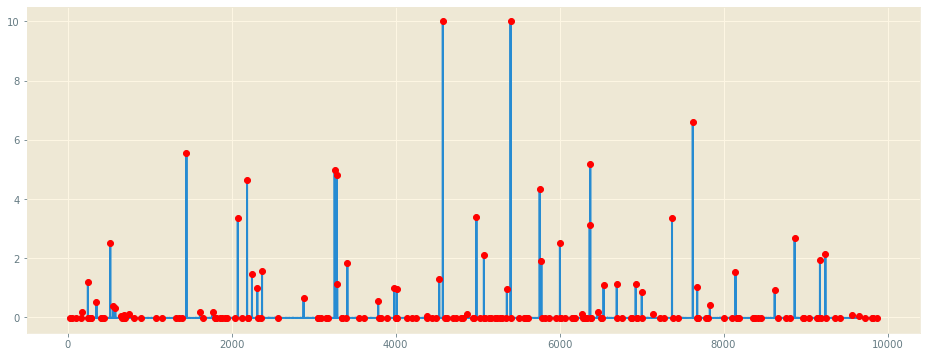

In [26]:
disp_anom(mse[:,0], ae)

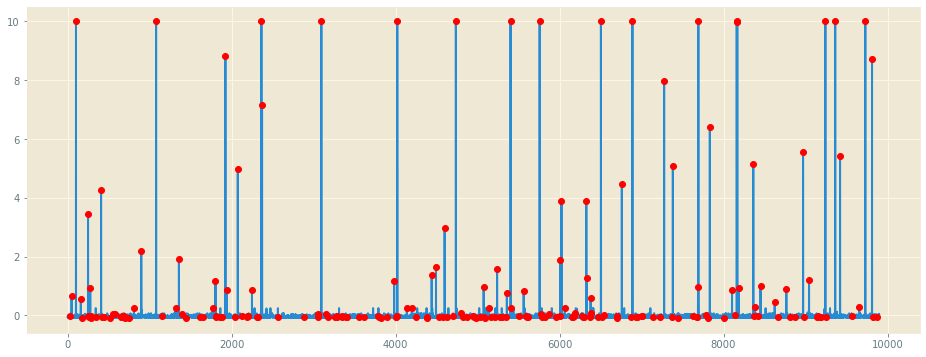

In [27]:
disp_anom(mse[:,1], ae)

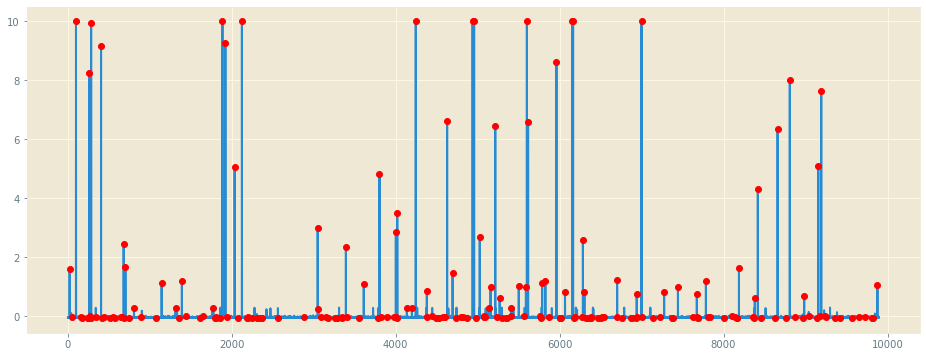

In [28]:
disp_anom(mse[:,2], ae)

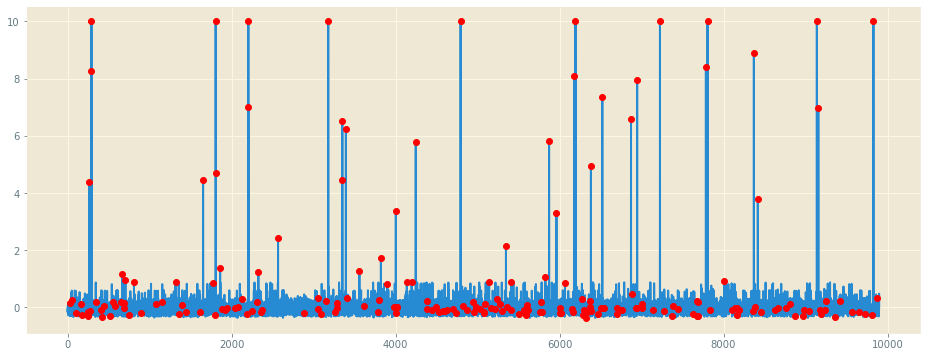

In [29]:
disp_anom(mse[:,3], ae)

In [30]:
#print(len(ad), ad)

In [31]:
#print(len(ae), ae)

In [32]:
print(a)

[  49  162  180  277  420  439  667  686  745 1147 1358 1394 1621 1804
 1861 1940 3059 3152 4009 4380 4381 4695 4819 4870 5074 5092 5158 5269
 5303 5502 5562 5589 5778 5788 6066 6269 6284 6303 6378 6702 6940 7443
 7673 7688 8008 8103 8380 8450 8623 8765 8866 8983 9042 9253 9654]


In [33]:
a2 = [int(i) for i in sorted(list(set(ad).difference(set(a))))]
print(len(a2), a2)

135 [25, 103, 248, 250, 267, 288, 292, 353, 409, 521, 555, 582, 684, 706, 899, 1080, 1450, 1653, 1806, 1807, 1889, 1925, 2037, 2076, 2126, 2189, 2202, 2205, 2249, 2314, 2327, 2364, 2372, 2567, 2878, 3050, 3095, 3179, 3257, 3281, 3288, 3347, 3351, 3394, 3412, 3559, 3612, 3788, 3804, 3821, 3899, 3983, 4003, 4015, 4021, 4246, 4440, 4493, 4532, 4576, 4598, 4629, 4735, 4793, 4939, 4958, 4986, 5026, 5077, 5216, 5238, 5346, 5357, 5402, 5601, 5616, 5757, 5827, 5872, 5962, 6004, 6006, 6023, 6155, 6165, 6178, 6194, 6326, 6333, 6367, 6374, 6382, 6463, 6504, 6521, 6536, 6697, 6759, 6871, 6888, 6928, 6946, 6999, 7002, 7224, 7275, 7371, 7381, 7624, 7678, 7692, 7784, 7804, 7832, 8145, 8160, 8167, 8187, 8362, 8369, 8417, 8658, 8807, 8969, 9137, 9155, 9175, 9191, 9241, 9361, 9420, 9728, 9810, 9827, 9876]


In [34]:
a3 = [int(i) for i in sorted(list(set(ae).difference(set(ad))))]
print(len(a3), a3)
len(a) + len(a2) + len(a3)

10 [648, 810, 1317, 1768, 4137, 4199, 5141, 5413, 7141, 9571]


200

In [35]:
c2 =[ np.argmax(abs(pred[i]-test[i])) for i in a2]    

In [36]:
print(c2)
np.save("spikes.npy", (a2,c2))

[801, 768, 1, 453, 1141, 1205, 1283, 278, 848, 270, 297, 207, 1047, 1149, 615, 691, 200, 1481, 1422, 1374, 801, 814, 890, 372, 798, 348, 1210, 1307, 300, 1, 1424, 601, 675, 1266, 35, 768, 485, 1239, 288, 173, 260, 1394, 1469, 1191, 154, 1358, 1120, 311, 913, 1197, 1445, 365, 1189, 271, 736, 1104, 627, 692, 13, 224, 732, 1057, 562, 1174, 1087, 1065, 56, 1027, 241, 969, 450, 1398, 95, 377, 885, 924, 388, 1180, 1505, 1110, 139, 716, 640, 1132, 976, 1495, 1322, 440, 609, 281, 171, 1211, 70, 703, 1267, 184, 282, 481, 1391, 442, 233, 1494, 904, 327, 1363, 715, 38, 564, 161, 104, 458, 1171, 1159, 456, 367, 702, 486, 785, 509, 1406, 1106, 1146, 1088, 647, 1345, 1455, 186, 934, 372, 736, 739, 562, 693, 1278, 1150]


In [37]:
print(96*16, max(c2))

1536 1505


In [38]:
c3 = []
ce = []
v = 0 
for i in a3:
    c = pred[i]-test[i]
    va = 0 
    for k in range(16):
        t = []
        for j in [0, N//4, N//2]:
            i1 = j+k*N 
            i2 = j+k*N+N//2
            t1  = np.square(c[i1:i2]).mean(axis=None)
            t.append(t1)
        val = max(t)
        if val > va:
            va = val
            e  = np.argmax(t) * 4*k
    c3.append((e+1)*N//4)
    ce.append(e)

In [92]:
print(a3,c3)
c3[9]=c3[9]-96

[648, 810, 1317, 1768, 4137, 4199, 5141, 5413, 7141, 9571] [1368, 1272, 1272, 1272, 1272, 1272, 1272, 1272, 1418, 1272]


9571


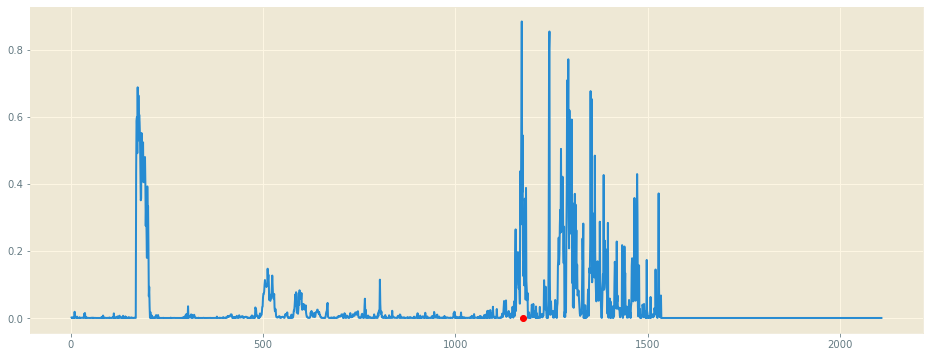

In [94]:
plt.figure(figsize=(16,6));
i = a3[9]
#plt.plot(test[i])
#plt.plot(pred[i])
print(i)
plt.plot(np.square(pred[i]-test[i]))
plt.plot(c3[9], 0, "ro")

5141


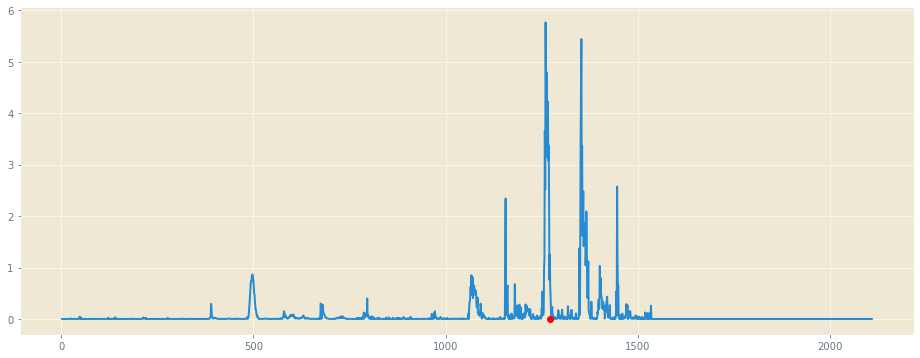

In [75]:
plt.figure(figsize=(16,6));
i = a3[6]
#plt.plot(test[i])
#plt.plot(pred[i])
print(i)
plt.plot(np.square(pred[i]-test[i]))
plt.plot(1272, 0, "ro")

In [42]:
[np.square(c[j:j+N//2]).mean(axis=None) for j in range(32)]

[0.00298654289284139,
 0.0030359468796085256,
 0.0030212360228556306,
 0.0034712131190002015,
 0.003466925294106006,
 0.003667506477666,
 0.0036675435841758883,
 0.003664665900213055,
 0.003664714496444755,
 0.0036661328433153454,
 0.0036679366780473185,
 0.003667816584652872,
 0.0036681755589900635,
 0.0036502495689278935,
 0.003726918432463142,
 0.0037354717512501946,
 0.003735447393828854,
 0.003704012289876784,
 0.0036751433655655523,
 0.0036746819488190402,
 0.003662120390830429,
 0.003659686252294097,
 0.00360040266665747,
 0.0035064447199740514,
 0.0033885416331966723,
 0.003356670554081531,
 0.0032553920170210193,
 0.003255337195415853,
 0.0032566827818581562,
 0.003235402521585006,
 0.003318430479917678,
 0.003353337900320937]

In [43]:
print(np.square(c[0:N//2]))
(np.square(c[0:N//2])).mean(axis=None) 


[4.65862387e-06 7.32935174e-04 1.15420488e-03 2.95791270e-04
 2.97755054e-04 2.16672911e-05 1.44015996e-04 2.20990782e-05
 2.32856723e-05 2.86350466e-04 9.58546691e-05 6.28241944e-06
 1.00499455e-03 2.94608627e-04 2.91859297e-04 5.82778009e-06
 1.51525446e-03 1.52847212e-03 2.66522390e-05 6.97571891e-04
 1.38619827e-04 2.87276462e-03 4.65535730e-03 5.93681413e-03
 1.53403649e-03 4.88135209e-03 1.06519149e-05 3.04129509e-04
 1.02567719e-03 9.20256911e-05 1.63098995e-05 9.20256911e-05
 1.13612983e-03 1.55612350e-03 2.17866716e-03 2.16612998e-03
 4.08179636e-04 8.18577823e-05 2.96436509e-06 1.57733163e-05
 2.83896615e-04 1.36960198e-06 1.67202388e-03 5.63749440e-04
 2.37557947e-03 2.98369863e-02 2.73385544e-02 4.37261676e-02]


0.00298654289284139

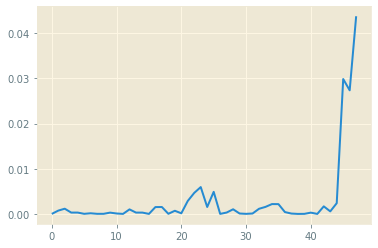

In [44]:
plt.plot(np.square(c[0:N//2])) 

In [45]:
#a1, c1 = broken_sensor(fixed,20)
#print(a1, c1)
#anomaly_1 = np.array([test[i, :] for i in a])
for i, j in enumerate(a):
    test[j, :] = fixed[i, :] 

NameError: name 'fixed' is not defined

In [ ]:
Anomaly1 = a
np.save("anom1.npy", Anomaly1)

In [ ]:
plt.figure(figsize=(20,6));
plt.plot(mse4)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sumup

In [ ]:
import inspect
lines = inspect.getsource(sumup)
print(lines)

In [ ]:
sns.distplot(mse2/sum(mse2))

In [ ]:
sns.distplot(mse3/sum(mse3))

In [ ]:
sns.distplot(mse4/sum(mse4))


In [ ]:
print(sum(mse1), sum(mse2), sum(mse3), sum(mse4))

In [ ]:
mse = mse1/sum(mse1) + mse2/sum(mse2) + mse3/sum(mse3) + mse4/sum(mse4) 
sns.distplot(mse)

In [ ]:
plt.figure(figsize=(20,6)); 
plt.plot(mse)
plt.plot(a, mse[a], "ro")

In [ ]:
plt.figure(figsize=(20,6)); 
plt.plot(mse1)
plt.plot(a, mse1[a], "ro")

In [ ]:
plt.figure(figsize=(20,6)); 
plt.plot(mse2)
plt.plot(a, mse2[a], "ro")

In [ ]:
plt.figure(figsize=(20,6)); 
plt.plot(mse3)
plt.plot(a, mse3[a], "ro")

In [ ]:
plt.figure(figsize=(20,6)); 
plt.plot(mse4)
plt.plot(a, mse4[a], "ro")

In [ ]:
def thrcurve(err):
    n_outliers = []
    thresholds = []
    n = 100
    maxe = max(err)
    mine = sum(err)/len(err)
    for i in reversed(range(n)):
        th = mine + i *(maxe-mine)/n
        a = len([e for e in err if e >th])
        if a > 300:
            #print(a, th, maxe)
            mine = th
            break
    for i in range(n):
        th = mine + i *(maxe-mine)/n
        n_outliers.append(len([e for e in err if e >th]))
        thresholds.append(th) 
    return thresholds, n_outliers

In [ ]:
thresholds, outliers = thrcurve(mse*10000)
plt.plot(thresholds, outliers)

In [ ]:
th = 0.0015
anom = [i for i, e in enumerate(mse) if e >th]
print(anom, len(anom))


In [ ]:
thresholds, outliers = thrcurve(mse1/sum(mse1)*10000)
plt.plot(thresholds, outliers)

In [ ]:
thresholds, outliers = thrcurve(mse2/sum(mse2)*10000)
plt.plot(thresholds, outliers)

In [ ]:
thresholds, outliers = thrcurve(mse3/sum(mse3)*10000)
plt.plot(thresholds, outliers)

In [ ]:
thresholds, outliers = thrcurve(mse4/sum(mse4)*10000)
plt.plot(thresholds, outliers)

In [ ]:
train_hum = train_red[:, N*3: N*4]
test_hum  = test_red[:,  N*3: N*4]
DL_Train_hum = DataLoader(train_hum.astype('float32'), batch_size=16, shuffle = True )
DL_Test_hum  = DataLoader( test_hum.astype('float32'), batch_size=1 , shuffle = False )
#model_hum, loss_hum = train_model( model, DL_Train_hum, targetDevice, nEpochs)
model_hum, loss_hum = train_model( model_hum, DL_Train_hum, targetDevice, nEpochs)

DL_Train_hum2 = DataLoader(test_hum.astype('float32'), batch_size=16, shuffle = True )
model_hum, loss_hum = train_model( model_hum, DL_Train_hum2, targetDevice, 20) 
torch.save( model_hum, "model_hum.v1.pth")


In [ ]:
plt.figure(figsize=(6,6));
plt.plot(loss_hum)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');


In [ ]:
mse_errors_hum = evaluate_model( model_hum, DL_Test_hum, targetDeviceGPU, len(test_red))
print(len(mse_errors_hum))
plt.figure(figsize=(16,6));
plt.plot(mse_errors_hum)

In [ ]:
plt.plot()

In [95]:
a1, c1 = np.load("broken_sensor.npy")

In [96]:
a1

array([  49,  162,  180,  277,  420,  439,  667,  686,  745, 1147, 1358,
       1394, 1621, 1804, 1861, 1940, 3059, 3152, 4009, 4380, 4381, 4695,
       4819, 4870, 5074, 5092, 5158, 5269, 5303, 5502, 5562, 5589, 5778,
       5788, 6066, 6269, 6284, 6303, 6378, 6702, 6940, 7443, 7673, 7688,
       8008, 8103, 8380, 8450, 8623, 8765, 8866, 8983, 9042, 9253, 9654])

In [97]:
c1

array([ 397,  448,  138,  547, 1327, 1316, 1477,  189,  320,  994,  675,
       1010,    9,  393, 1421,  623, 1131, 1443, 1168,  275,  990, 1107,
       1168,   99,  423, 1308, 1070,  970,   91, 1004,  523,  864,  249,
        971,  954,  270,  923, 1131,  623,  925,  949,  904,  857,  623,
       1403,  510,  741,  590,  365,  519,  214, 1137,  588, 1264,  359])

In [98]:
np.save("spikes_type1.npy", a2, c2)

In [99]:
np.save("spikes_type3.npy", a3, c3)

In [103]:
for i in range(len(a1)):
    print(a1[i]+1, ", ", c1[i])

50 ,  397
163 ,  448
181 ,  138
278 ,  547
421 ,  1327
440 ,  1316
668 ,  1477
687 ,  189
746 ,  320
1148 ,  994
1359 ,  675
1395 ,  1010
1622 ,  9
1805 ,  393
1862 ,  1421
1941 ,  623
3060 ,  1131
3153 ,  1443
4010 ,  1168
4381 ,  275
4382 ,  990
4696 ,  1107
4820 ,  1168
4871 ,  99
5075 ,  423
5093 ,  1308
5159 ,  1070
5270 ,  970
5304 ,  91
5503 ,  1004
5563 ,  523
5590 ,  864
5779 ,  249
5789 ,  971
6067 ,  954
6270 ,  270
6285 ,  923
6304 ,  1131
6379 ,  623
6703 ,  925
6941 ,  949
7444 ,  904
7674 ,  857
7689 ,  623
8009 ,  1403
8104 ,  510
8381 ,  741
8451 ,  590
8624 ,  365
8766 ,  519
8867 ,  214
8984 ,  1137
9043 ,  588
9254 ,  1264
9655 ,  359


In [104]:
for i in range(len(a2)):
    print(a2[i]+1, ", ", c2[i])

26 ,  801
104 ,  768
249 ,  1
251 ,  453
268 ,  1141
289 ,  1205
293 ,  1283
354 ,  278
410 ,  848
522 ,  270
556 ,  297
583 ,  207
685 ,  1047
707 ,  1149
900 ,  615
1081 ,  691
1451 ,  200
1654 ,  1481
1807 ,  1422
1808 ,  1374
1890 ,  801
1926 ,  814
2038 ,  890
2077 ,  372
2127 ,  798
2190 ,  348
2203 ,  1210
2206 ,  1307
2250 ,  300
2315 ,  1
2328 ,  1424
2365 ,  601
2373 ,  675
2568 ,  1266
2879 ,  35
3051 ,  768
3096 ,  485
3180 ,  1239
3258 ,  288
3282 ,  173
3289 ,  260
3348 ,  1394
3352 ,  1469
3395 ,  1191
3413 ,  154
3560 ,  1358
3613 ,  1120
3789 ,  311
3805 ,  913
3822 ,  1197
3900 ,  1445
3984 ,  365
4004 ,  1189
4016 ,  271
4022 ,  736
4247 ,  1104
4441 ,  627
4494 ,  692
4533 ,  13
4577 ,  224
4599 ,  732
4630 ,  1057
4736 ,  562
4794 ,  1174
4940 ,  1087
4959 ,  1065
4987 ,  56
5027 ,  1027
5078 ,  241
5217 ,  969
5239 ,  450
5347 ,  1398
5358 ,  95
5403 ,  377
5602 ,  885
5617 ,  924
5758 ,  388
5828 ,  1180
5873 ,  1505
5963 ,  1110
6005 ,  139
6007 ,  716
6024 ,  6

In [105]:
for i in range(len(a3)):
    print(a3[i]+1, ", ", c3[i])

649 ,  1368
811 ,  1272
1318 ,  1272
1769 ,  1272
4138 ,  1272
4200 ,  1272
5142 ,  1272
5414 ,  1272
7142 ,  1418
9572 ,  1176
